<a href="https://colab.research.google.com/github/Dipak22/DeepLearning/blob/master/MLP_character_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import requests
import torch

with open('names.txt','wb') as f:
  content = requests.get('https://github.com/karpathy/makemore/raw/master/names.txt')
  f.write(content.content)

In [3]:
words = open('names.txt','r').read().splitlines()
len(words)

32033

In [4]:
chars = sorted(list(set(''.join(words))))


In [5]:
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] =0
itos = {i: c for c,i in stoi.items()}
itos

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

In [6]:
#create the dataset for the MLP model
def build_dataset(words):
  context_length = 3
  xs = []
  ys = []
  for word in words:
    context = [0]*3
    for c in word+'.':
      xs.append(context)
      ix = stoi[c]
      ys.append(ix)
      #print(f"input {''.join(itos[i] for i in context)} output = {c}")
      context = context[1:] + [ix]
  X = torch.tensor(xs)
  y = torch.tensor(ys)
  return X,y

In [7]:
#create train , val and test dataset
import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))
X_train, y_train = build_dataset(words[:n1])
X_val, y_val = build_dataset(words[n1:n2])
X_test, y_test = build_dataset(words[n2:])
print(f" Train data shapes {X_train.shape} {y_train.shape}")
print(f" Validation data shapes {X_val.shape} {y_val.shape}")
print(f" Test data shapes {X_test.shape} {y_test.shape}")

 Train data shapes torch.Size([182625, 3]) torch.Size([182625])
 Validation data shapes torch.Size([22655, 3]) torch.Size([22655])
 Test data shapes torch.Size([22866, 3]) torch.Size([22866])


In [8]:
from torch import nn
import torch.nn.functional as F

In [34]:
# define the MLP model
class MLPModel(nn.Module):
  def __init__(self,vocab_size = 27,embedding_size = 2, context_length =3, hidden_units =100, output_shape= 27):
    super().__init__()
    #Embedding layer
    self.embedding = nn.Embedding(vocab_size, embedding_size)
    #Parameters
    #self.W1 = nn.Parameter(torch.randn((context_length * embedding_size,hidden_units)))
    #self.b1 = nn.Parameter(torch.randn(hidden_units))
    #self.W2 = nn.Parameter(torch.randn((hidden_units, output_shape)))
    #self.b2 = nn.Parameter(torch.randn(output_shape))
    self.linear_1 = nn.Linear(in_features= context_length * embedding_size, out_features=hidden_units, bias=False)
    self.bn_1 = nn.BatchNorm1d(num_features=hidden_units)
    self.non_linear = nn.Tanh()
    self.linear_2 = nn.Linear(in_features= hidden_units, out_features=hidden_units, bias=False)
    self.bn_2 = nn.BatchNorm1d(num_features=hidden_units)
    self.linear_3 = nn.Linear(in_features= hidden_units, out_features=output_shape, bias=False)
    self.bn_3 = nn.BatchNorm1d(num_features=output_shape)
    #self.count = 0

  def forward(self,X):
    emb = self.embedding(X)
    #print(emb.shape)
    h = self.linear_1(emb.view(X.shape[0], -1))
    #print(h.shape)
    h = self.bn_1(h)
    #print(h.shape)
    h = self.non_linear(h)
    #print(h.shape)
    h = self.non_linear(self.bn_2(self.linear_2(h)))
    #print(h.shape)
    logits = self.bn_3(self.linear_3(h))
    #print(logits.shape)
    #self.count +=1
    #print(f"count: {self.count}")

    return logits

In [10]:
# create Dataloaders
from torch.utils.data import TensorDataset, DataLoader

In [35]:
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True, drop_last=True)
for batch_X, batch_y in train_dataloader:
    print("Batch X shape:", batch_X.shape)  # (32, 3)
    print("Batch y shape:", batch_y.shape)  # (32,)
    break  # Only process the first batch for demonstration
val_dataset = TensorDataset(X_val, y_val)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=False)
for batch_X, batch_y in val_dataloader:
    print("Val Batch X shape:", batch_X.shape)  # (32, 3)
    print("Val Batch y shape:", batch_y.shape)  # (32,)
    break  # Only process the first batch for demonstration

Batch X shape: torch.Size([32, 3])
Batch y shape: torch.Size([32])
Val Batch X shape: torch.Size([32, 3])
Val Batch y shape: torch.Size([32])


In [36]:
len(train_dataloader), 5708 * 32,182656 - 182625

(5707, 182656, 31)

In [37]:
#train step
def train_step(model:torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn : torch.nn.Module,
               optimizer: torch.optim.Optimizer):

  train_loss = 0
  for X, y in dataloader:
    model.train()
    logits = model(X)
    loss = loss_fn(logits, y)
    train_loss +=loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss /=len(dataloader)
  return train_loss


In [38]:
#Training
model = MLPModel(vocab_size=27,
                 embedding_size=10,
                 context_length=3,
                 hidden_units=100,
                 output_shape=27)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(),
                            lr = 0.1)
for _ in range(1):
  print(train_step(model=model, dataloader=train_dataloader, loss_fn=loss_fn, optimizer= optimizer))

2.382526726966692


In [39]:
def test_step(model:torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
  model.eval()
  test_loss =0
  with torch.inference_mode():
    for X,y in dataloader:
      logits = model(X)
      loss = loss_fn(logits, y)
      test_loss +=loss.item()
  test_loss /=len(dataloader)
  return test_loss

In [40]:
from tqdm.auto import tqdm
def train(model : torch.nn.Module,
          train_dataloader : torch.utils.data.DataLoader,
          test_dataloader : torch.utils.data.DataLoader,
          loss_fn : torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          epochs : int = 3):
  results = {'train_loss':[],'val_loss':[]}
  for epoch in tqdm(range(epochs)):
    train_loss = train_step(model= model,
                            dataloader=train_dataloader,
                            loss_fn=loss_fn,
                            optimizer= optimizer)
    val_loss = test_step(model=model,
                         dataloader=test_dataloader,
                         loss_fn=loss_fn)
    print(f"Epoch : {epoch} | Train loss: {train_loss} | Test loss: {val_loss}")
    results['train_loss'].append(train_loss)
    results['val_loss'].append(val_loss)
  return results



In [41]:
#Training
model = MLPModel(vocab_size=27,
                 embedding_size=10,
                 context_length=3,
                 hidden_units=100,
                 output_shape=27)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(),
                            lr = 0.1)


In [42]:
from timeit import default_timer as timer
start_time = timer()
model_results = train(model = model,
                      train_dataloader=train_dataloader,
                      test_dataloader=val_dataloader,
                      loss_fn=loss_fn,
                      optimizer=optimizer,
                      epochs=2)
end_time = timer()
print(f"Total training time: {end_time - start_time:.3f} seconds")

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 0 | Train loss: 2.375133672152423 | Test loss: 2.2641817743832107
Epoch : 1 | Train loss: 2.2753719933421093 | Test loss: 2.22275162063076
Total training time: 24.210 seconds


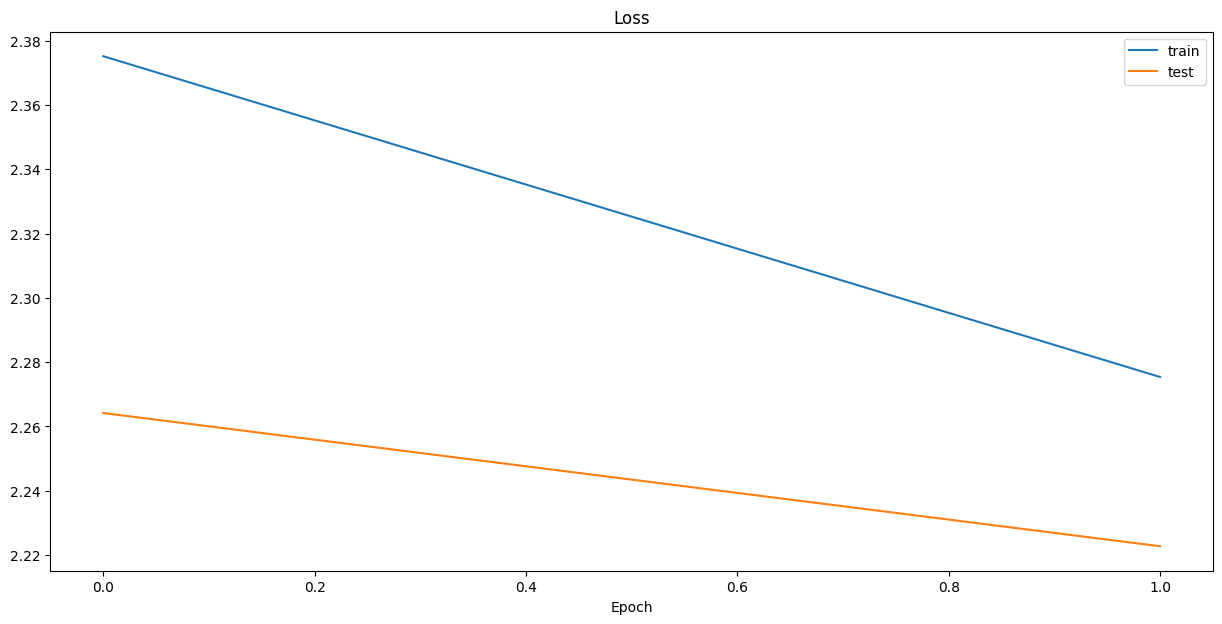

In [43]:
import matplotlib.pyplot as plt

def plot_loss(results):
  train_loss = results['train_loss']
  test_loss = results['val_loss']
  epochs = range(len(results['train_loss']))
  plt.figure(figsize=(15,7))
  plt.plot(epochs,train_loss, label='train')
  plt.plot(epochs,test_loss, label='test')
  plt.title('Loss')
  plt.xlabel('Epoch')
  plt.legend();

plot_loss(model_results)


In [47]:
#sample words
for _ in range(10):
  out=[]
  context=[0]*3
  while True:
    logits = model(torch.tensor([context]))
    probs = F.softmax(logits, dim =1)
    ix = torch.multinomial(probs, num_samples=1, replacement=True).item()
    context = context[1:]+ [ix]
    out.append(ix)
    if ix ==0:
      break
  print(''.join(itos[i] for i in out))

soriu.
qui.
p.
kantas.
zaklie.
soh.
nakhowozmyn.
kari.
jaymaa.
sta.
